In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import qtensor.states as states 
import qtensor.operators as ops
from qtensor.simulation.finiteTDVP import tdvp, right_mpo_contractions, gs_evolve
import qtensor.simulation.finiteTDVP as sim
import qtensor.thermofield as thf 
import ncon

Basic state

In [3]:
N=10
D=6

psi = states.random_mps(N, 2, D, seed=42)
psi.right_canonical()

H = ops.tilted_ising(N=N)
H_term = ops.extensive_twosite_local_term(H, 3)

H_spin_up = ops.tilted_ising(J=0, h=1, g=0, N=N)


Simple TDVP

Initiating TDVP
TDVP finished!
Method: method_exact, Time taken: 3.77 seconds


c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


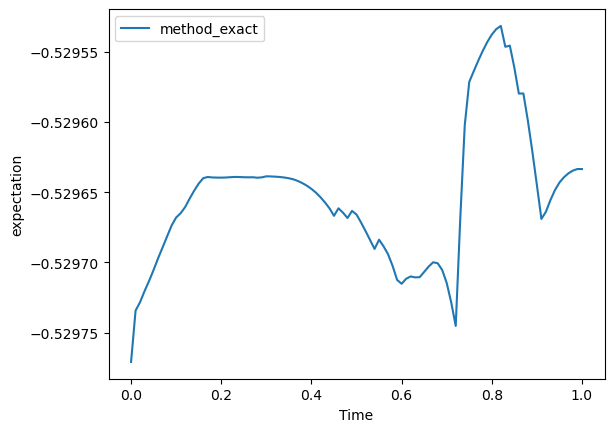

In [4]:
import time

t_f = 1
steps = 100
methods = [sim.method_exact]

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Time')
ax.set_ylabel('expectation')
for method in methods:
    psi_copy = copy.deepcopy(psi)
    ti = time.time()
    s_hist, _ = tdvp(psi_copy, H, t_f, steps, method=method, history=True)
    t_real = time.time() - ti
    print(f"Method: {str(method).split()[1]}, Time taken: {t_real:.2f} seconds")   
    t = list(s_hist.keys())
    expecs = [ops.local_expect(state, H_term) for state in s_hist.values()]
    ax.plot(t, expecs, label=str(method).split()[1])
ax.legend()


Ground state evolve

In [5]:
psi = gs_evolve(psi, H_spin_up, 1000, 100)

Intial energy: (-0.24798775449688892+4.1199682554448774e-17j)
Initiating TDVP
TDVP finished!
Final energy: (-9.99999981771035+9.360645398083498e-16j)


Thermofield stuff

In [6]:
N = 8
D = 8
H_usual = ops.tilted_ising(N=N)
beta = 1
H_th = thf.thermofield_hamiltonian(H_usual)


In [7]:
beta_psi, times, energies = thf.finite_T_thermofield(beta, N, D, H_th, steps=200)

TypeError: inf_T_thermofield_variational() missing 2 required positional arguments: 't_f' and 'steps'

In [8]:
# compare this to the groundstate energy
randpsi = states.random_mps(N, 2, D)
gs_evolve(randpsi, H_usual)

Intial energy: (-4.162048062445335-4.426325008087262e-16j)
Initiating TDVP
TDVP finished!
Final energy: (-9.590983998497517+3.469446951953614e-16j)


Testing near thermal ansatz builder

In [51]:
N = 31
D = 6
H_usual = ops.tilted_ising(N=N)
H_tf = thf.thermofield_hamiltonian(H_usual)
H_check_before = copy.deepcopy(H_tf[2])
H_middle = ops.extensive_twosite_local_term(H_tf, int((N-1)/2))
H_check_after = copy.deepcopy(H_tf[2])

assert np.allclose(H_check_before, H_check_after), "The two Hamiltonians should be equal before the contraction."

beta_avg = 0.05
delta_beta = 0.001
sigma = 1

In [52]:
inf_T_state = sim.inf_T_thermofield_variational(N, D, 1000, 100, seed=1)

Intial energy: (-30.4348537443347+1.111090386363122e-15j)
Initiating TDVP
TDVP finished!
Final energy: (-93.00000000000017-1.5064338665382593e-14j)


Initiating TDVP
TDVP finished!
Energy at finite temperature: -2.0404371364293095


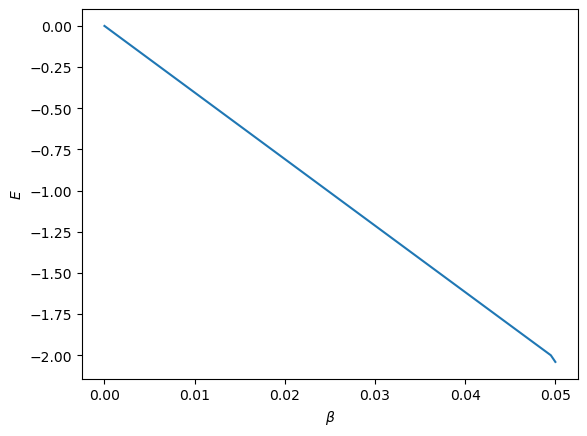

In [53]:
working_state = copy.deepcopy(inf_T_state)
even_state = thf.finite_T_thermofield(beta_avg, N, D, H_tf, initial_state=working_state)[0]

In [54]:
# gaussian profile ontop of an average, 
# with temp highest at centre,
# adjusted to have zero mean
d_beta_profile = delta_beta*np.exp(-(np.linspace(-N/2, N/2, N)**2)/(2*sigma**2))
d_beta_profile = d_beta_profile - np.mean(d_beta_profile)*np.ones(N)

beta_profile = beta_avg*np.ones(N) - d_beta_profile
 
working_state = copy.deepcopy(inf_T_state)
profile_state = thf.near_thermal(H_tf, beta_profile, D, initial_state=working_state)

Initiating TDVP
TDVP finished!


In [55]:
# Checking energy along chain
inft_energy = []
local_energy = []
even_energy = []
sites = sorted(list(H_usual.sites))
local_ops = ops.extensive_as_terms(H_tf)
for term in local_ops:
    inft_energy.append(ops.local_expect(inf_T_state, term))
    local_energy.append(ops.local_expect(profile_state, term))
    even_energy.append(ops.local_expect(even_state, term))

c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Bond')

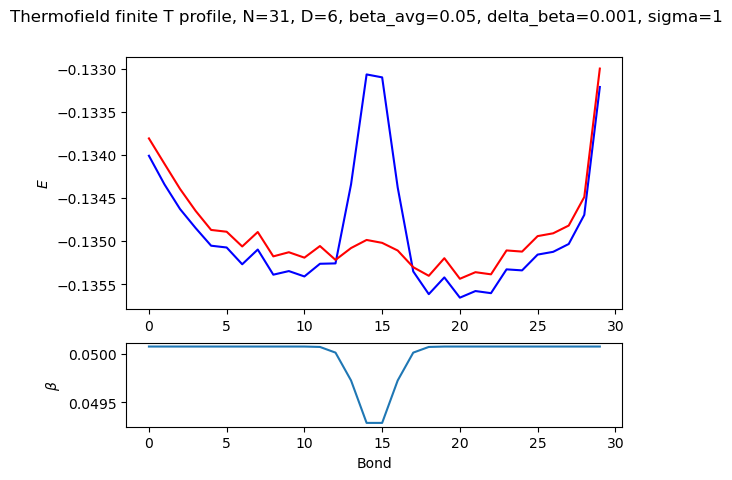

In [56]:
fig, ax = plt.subplots(2, 1, height_ratios=[3, 1])
# ax[0,].plot(sites[:-1], inft_energy, color='k', label='Infinite T')
fig.suptitle(f"Thermofield finite T profile, N={N}, D={D}, beta_avg={beta_avg}, delta_beta={delta_beta}, sigma={sigma}")
ax[0,].plot(sites[:-1], local_energy, color='b', label='Profile T')
ax[0,].plot(sites[:-1], even_energy, color='r', label='Finite T')
ax[0,].set_ylabel(r'$E$')
bond_profile = [np.sqrt(beta_profile[i]*beta_profile[i+1]) for i in range(N-1)]
ax[1,].plot(sites[:-1], bond_profile)
ax[1,].set_ylabel(r'$\beta$')
ax[1,].set_xlabel("Bond")

Do real time evolution on almost-thermal state

In [57]:
initial_state = copy.deepcopy(profile_state)
t_f = 2
n_steps = 200
# evolved_state, expectations = sim.tdvp(initial_state, H_tf, t_f, n_steps, operators=local_ops)
evolved_state, expectations = sim.tdvp(initial_state,
 H_tf, t_f, n_steps, sim.method_exact,
                                       history=True, 
                                       verbose=True, 
                                       operators=[H_tf, H_middle])


Initiating TDVP
t: 0.000
t: 0.010
t: 0.020
t: 0.030
t: 0.040
t: 0.050
t: 0.060
t: 0.070
t: 0.080
t: 0.090
t: 0.100
t: 0.110
t: 0.120
t: 0.130
t: 0.140
t: 0.150
t: 0.160
t: 0.170
t: 0.180
t: 0.190
t: 0.200
t: 0.210
t: 0.220
t: 0.230
t: 0.240
t: 0.250
t: 0.260
t: 0.270
t: 0.280
t: 0.290
t: 0.300
t: 0.310
t: 0.320
t: 0.330
t: 0.340
t: 0.350
t: 0.360
t: 0.370
t: 0.380
t: 0.390
t: 0.400
t: 0.410
t: 0.420
t: 0.430
t: 0.440
t: 0.450
t: 0.460
t: 0.470
t: 0.480
t: 0.490
t: 0.500
t: 0.510
t: 0.520
t: 0.530
t: 0.540
t: 0.550
t: 0.560
t: 0.570
t: 0.580
t: 0.590
t: 0.600
t: 0.610
t: 0.620
t: 0.630
t: 0.640
t: 0.650
t: 0.660
t: 0.670
t: 0.680
t: 0.690
t: 0.700
t: 0.710
t: 0.720
t: 0.730
t: 0.740
t: 0.750
t: 0.760
t: 0.770
t: 0.780
t: 0.790
t: 0.800
t: 0.810
t: 0.820
t: 0.830
t: 0.840
t: 0.850
t: 0.860
t: 0.870
t: 0.880
t: 0.890
t: 0.900
t: 0.910
t: 0.920
t: 0.930
t: 0.940
t: 0.950
t: 0.960
t: 0.970
t: 0.980
t: 0.990
t: 1.000
t: 1.010
t: 1.020
t: 1.030
t: 1.040
t: 1.050
t: 1.060
t: 1.070
t: 1.080
t: 

Text(0.5, 0.98, 'Time-evolved T profile, N=31, D=6, beta_avg=0.05, delta_beta=0.001, sigma=1')

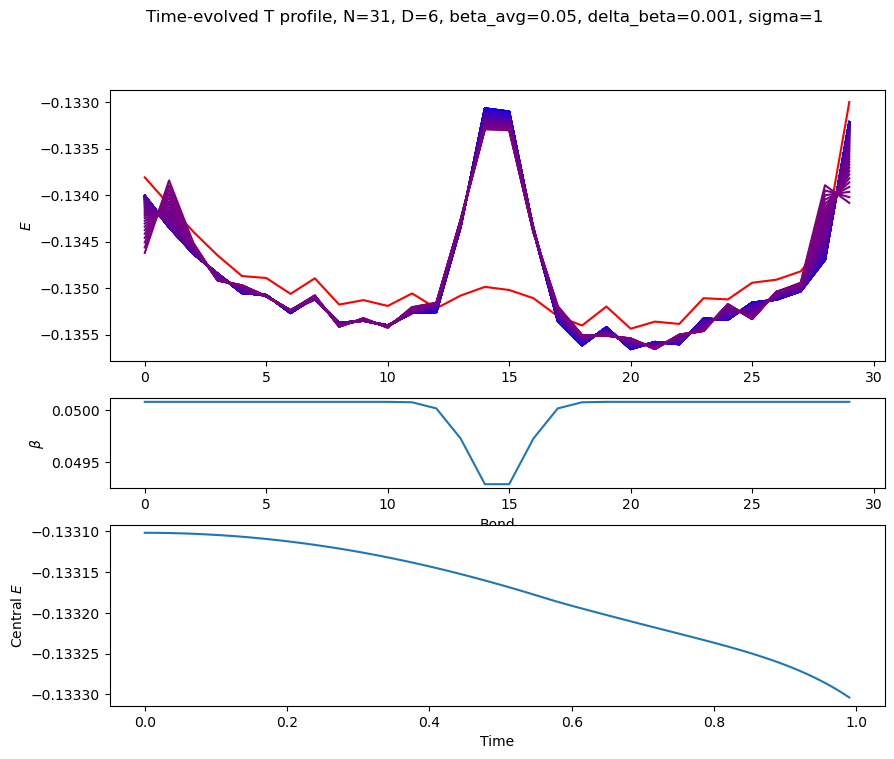

In [60]:
fig, ax = plt.subplots(3, 1, height_ratios=[3, 1, 2], figsize=(10, 8))
fig.suptitle(f"Time-evolved T profile, N={N}, D={D}, beta_avg={beta_avg}, delta_beta={delta_beta}, sigma={sigma}")
ax[0,].plot(sites[:-1], local_energy, color='b')
ax[0,].plot(sites[:-1], even_energy, color='r')
ax[0,].set_ylabel(r'$E$')
bond_profile = [np.sqrt(beta_profile[i]*beta_profile[i+1]) for i in range(N-1)]
ax[1,].plot(sites[:-1], bond_profile)
ax[1,].set_ylabel(r'$\beta$')
ax[1,].set_xlabel("Bond")


times = evolved_state.keys()
E_profile={}
for t in times:
    if t < 1:
        E_profile[t] = [ops.local_expect(evolved_state[t], op) for op in local_ops]
        ax[0,].plot(sites[:-1], E_profile[t], color=(t/t_f, 0, 1-t/t_f))


middle_energy = [expectations[t][1] for t in times]
ax[2,].plot(list(times)[:100], middle_energy[:100])
ax[2,].set_xlabel("Time")
ax[2,].set_ylabel(r'Central $E$')

fig.suptitle(f"Time-evolved T profile, N={N}, D={D}, beta_avg={beta_avg}, delta_beta={delta_beta}, sigma={sigma}")


(4.0, 12.0)